In [1]:
!nvidia-smi

Fri Jan 24 12:40:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K20Xm         On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P8    19W / 235W |      0MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K20Xm         On   | 00000000:84:00.0 Off |                    0 |
| N/A   51C    P8    18W / 235W |      0MiB /  5700MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
go = False
if go:
    
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
    import tensorflow as tf
    from keras import backend as K

    set_gpu=True

    if set_gpu:
        os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
        os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
        print(os.environ["CUDA_VISIBLE_DEVICES"])


        num_cores = 39

        GPU=True
        CPU=False

        if GPU:
            num_GPU = 1
            num_CPU = 1
        if CPU:
            num_CPU = 1
            num_GPU = 0

        config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                                inter_op_parallelism_threads=num_cores, 
                                allow_soft_placement=True,
                                device_count = {'CPU' : num_CPU,
                                                'GPU' : num_GPU}
                               )

        session = tf.Session(config=config)
        K.set_session(session)


In [3]:
#!wget https://raw.githubusercontent.com/DBertazioli/host/master/datas/df_final_processed.csv

In [4]:
#!pip install pyforest
#from pyforest import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import keras


df = pd.read_csv("../data/df_final_processed.csv", index_col = 0)
df.head()

from keras.preprocessing.sequence import TimeseriesGenerator

#some zeroes
#series = df.level_scaled.values
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0.01, 1))

series = sc.fit_transform(df.level.values.reshape(-1, 1))

split_index = -7*24

#test_series = series [split_index:]
#series = series [:split_index]
n_features = 1
#series = series.reshape((len(series), n_features))
#test_series = test_series.reshape((len(test_series), n_features))

series.shape


Using TensorFlow backend.
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/intel/intelpython3/lib/python3.6/site-packages/t

(78888, 1)

In [84]:
# 24h ahead single preds
padded_series = np.expand_dims(np.concatenate([series.flatten(), series.mean()*np.ones(23)]), axis = -1)
padded_series

target_series = np.roll(padded_series, -23)[:series.shape[0]] #need to discard the last as well

In [92]:
target_series[:-23].shape, series[:-23].shape

((78865, 1), (78865, 1))

In [113]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, CuDNNLSTM, LeakyReLU, Dropout, BatchNormalization
from keras.utils import multi_gpu_model
from keras import backend as K
from keras.optimizers import Adam 


# define model
def make_model(n_input, n_features, 
               verbose = False, multi = True, use_CuDNNLSTM = True,
              loss = "mse", metrics = ["mae", "mape"],
              lr = 0.001):
    K.clear_session()
    LSTM_layer = LSTM if not use_CuDNNLSTM else CuDNNLSTM
    opt = Adam (lr = lr )
    
    model = Sequential()
    
    model.add(LSTM_layer(512, input_shape=(n_input, n_features), return_sequences=True))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.3))
    for i in range(0):
        model.add(LSTM_layer(512, return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout( rate = 0.4))
    
    for i in range(1):
        model.add(LSTM_layer(256, return_sequences = False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(rate = 0.3))

    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(rate = 0.2))
    
    model.add(Dense(1))
    
    model.compile(optimizer=opt, loss=loss, metrics = metrics)
    if verbose:
        model.summary()
    if multi:
        mmodel = multi_gpu_model(model, 2)
        mmodel.compile(optimizer=opt, loss=loss, metrics = metrics)
        return mmodel, model
    else: 
        
        return None, model

In [96]:
n_input = 1*24*1
gen_batch_size = 256

# define generator
split_index = -168-1
train_generator = TimeseriesGenerator(series[:split_index], target_series[:split_index], length=n_input, batch_size=gen_batch_size)
train_list = []
test_list = []
for train,test in train_generator:
    train_list.append(train)
    test_list.append(test)
train_input = np.concatenate(train_list, axis = 0)
train_targets = np.concatenate(test_list, axis = 0)

In [97]:
train_input.shape, train_targets.shape

((78695, 24, 1), (78695, 1))

In [98]:
ttest_generator = TimeseriesGenerator(series[-n_input + split_index:-23], target_series[-n_input + split_index:-23], length=n_input, batch_size=len(target_series[-n_input + split_index:]), shuffle=False) #a whole batch size for faster splitting after the padding zone

train_test, test_test = ttest_generator[0]

train_test.shape, test_test.shape

val_train, val_test = train_test[:-1],test_test[:-1] #@-20 index starts the paddings due to h24 preds

In [99]:
val_train.shape, val_test.shape

((145, 24, 1), (145, 1))

In [100]:
import wandb
wandb.login()


True

In [110]:
from wandb.keras import WandbCallback as wb

wandb.init(project = "venice_is_drowing", name = "lstm_single_output_test_24h")
cfg = wandb.config
n_input = 1*24
batch_size = 256
cfg.batch_size = batch_size
cfg.n_features = n_features
cfg.n_input = n_input
cfg.epochs = 150

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [114]:
mmodel, model = make_model(n_input, n_features, lr = 0.001,
                           multi = True, use_CuDNNLSTM = True, verbose = True,
                           loss = "mse", metrics = ["mae", "mape"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 24, 512)           1054720   
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 512)           2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 512)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 512)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 256)               788480    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
__________

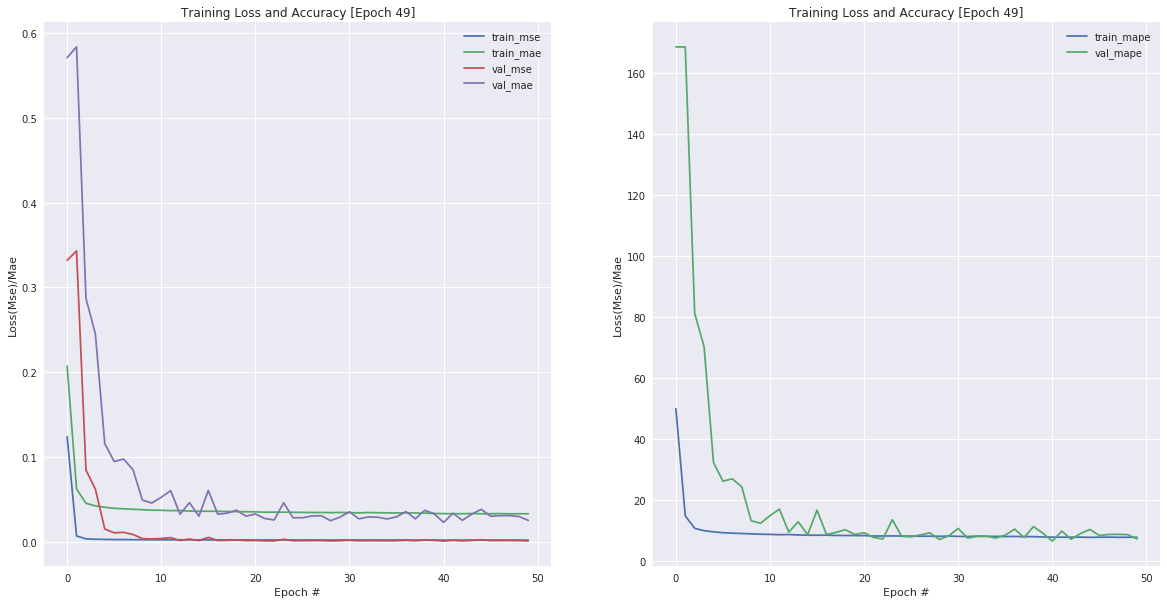

Epoch 51/150
78695/78695 [==============================] - 18s 229us/step - loss: 0.0021 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 7.9716 - val_loss: 0.0026 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 11.8726
Epoch 52/150
78695/78695 [==============================] - 22s 279us/step - loss: 0.0020 - mean_absolute_error: 0.0330 - mean_absolute_percentage_error: 7.9272 - val_loss: 0.0012 - val_mean_absolute_error: 0.0261 - val_mean_absolute_percentage_error: 7.4598
Epoch 53/150
78695/78695 [==============================] - 29s 365us/step - loss: 0.0020 - mean_absolute_error: 0.0328 - mean_absolute_percentage_error: 7.8378 - val_loss: 0.0011 - val_mean_absolute_error: 0.0253 - val_mean_absolute_percentage_error: 7.3238

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 54/150
78695/78695 [==============================] - 32s 407us/step - loss: 0.0020 - mean_absolute_error: 0.0326 - mean_absolute_perce

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from myutils import TrainingPlot


plot_losses = TrainingPlot()
es = EarlyStopping(monitor = "val_loss", patience = 50, restore_best_weights = True, verbose = 1)
rl = ReduceLROnPlateau(monitor = "val_loss", patience = 10, cooldown=5, factor=0.5, verbose = 1)

# fit model
history = mmodel.fit(
    train_input, train_targets,
    epochs=cfg.epochs,
    batch_size = cfg.batch_size,
    
    verbose=1, 
    
    #validation_data=ttest_generator, 
    #validation_steps = 6,
    validation_data = (val_train, val_test),
    
    callbacks=[plot_losses, 
              es, rl,
              wb(log_gradients=False, log_weights=False)
              ]
)

In [16]:
model.save("lstm_mape_single_24_step_ahead_y_10_18.h5")

In [37]:
init_test_arr = series[-n_input+split_index:split_index]
test_features = np.squeeze(init_test_arr, axis = -1).tolist()
test_features.append(3)
np.atleast_3d(test_features[-n_input:])

array([[[0.586 ],
        [0.5455],
        [0.478 ],
        [0.4285],
        [0.397 ],
        [0.4015],
        [0.4465],
        [0.514 ],
        [0.577 ],
        [0.6175],
        [0.6445],
        [0.64  ],
        [0.577 ],
        [0.4825],
        [0.397 ],
        [0.3025],
        [0.217 ],
        [0.181 ],
        [0.1855],
        [0.2485],
        [0.343 ],
        [0.433 ],
        [0.5005],
        [3.    ]]])

In [41]:
pred = model.predict(np.expand_dims(init_test_arr, axis = 0))
pred[0][0]

0.5466113

In [87]:
def iterate_prediction(input_seq = series[-n_input+split_index:split_index], pred_len = 168):
    init_test_arr = np.expand_dims(input_seq, axis = 0)
    preds = []
    for i in range(pred_len):
        test_features = np.squeeze(np.squeeze(init_test_arr, axis = -1), axis = 0).tolist()
        pred = model.predict(init_test_arr)[0][0]
        preds.append(pred)
        test_features.append(pred)
        init_test_arr = np.atleast_3d(test_features[-n_input:])

    return np.array(preds)

preds = iterate_prediction()



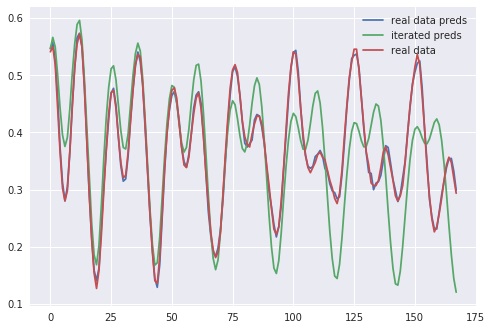

In [90]:
real_preds = model.predict_generator(test_generator).flatten()
real_data = series[split_index:].flatten()

def plot_preds(real_preds, real_data, preds):
    plt.plot(real_preds, label = "real data preds")
    plt.plot(preds, label = "iterated preds")
    plt.plot(real_data, label = "real data")
    plt.legend()
    plt.show()

plot_preds(real_preds, real_data, preds)

In [100]:
real_data[0:10],preds[0:10]

(array([0.541 , 0.55  , 0.5185, 0.442 , 0.3655, 0.3025, 0.28  , 0.298 ,
        0.3655, 0.442 ]),
 array([0.5466113 , 0.5661252 , 0.5493545 , 0.50055414, 0.44217643,
        0.39538738, 0.37536237, 0.39117736, 0.44077906, 0.50194985],
       dtype=float32))

In [97]:
def calc_mape(real, pred):
    return (100*np.abs(real-pred)/real/real.shape[0]).sum()
print(calc_mape(real_data, real_preds)) #mape on real-data preds
print(calc_mape(real_data, preds)) #mape on iterated preds
print(calc_mape(real_data[0:1], preds[0:1]))

1.7629865651533154
18.710233655825192
1.0372105455663119


In [ ]:
pred_generator = TimeseriesGenerator(series[-n_input + split_index:], series[-n_input + split_index:], length=n_input, batch_size=1)
mmodel.predict_generator(test_generator, steps=1)[0]

In [ ]:
test_series = series[split_index:]
test_series[0]

In [ ]:
mape = (test_series[0]-mmodel.predict_generator(test_generator, steps=1)[0])/test_series[0]
mape

In [ ]:
#plt.plot(history1.history["mean_absolute_error"], label = "mae")
#plt.plot(history1.history["mean_absolute_percentage_error"], label = "mape")
#plt.plot(history1.history["val_mean_absolute_error"], label = "val_mae")
plt.plot(history1.history["val_mean_absolute_percentage_error"], label = "val_mse")
#plt.ylim((0,1))
plt.legend()
plt.plot()

In [ ]:
plt.plot(test_series[1:])
plt.plot(model.predict_generator(test_generator)[:-1])

In [ ]:
for x, y in test_generator:
  print(x)
  print("#")
  print(y)
  break

In [ ]:
model.evaluate_generator(test_generator)